# Linear Model Selection and Regularisation

In [220]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator
from functools import partial
from itertools import combinations

**1. Forward and backward stepwise regression with simulated data**

*(a) Create a random number generator and use its `normal()` method to generate a predictor X of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.*

In [221]:
np.random.seed(42)
X = np.random.randn(100)
e = np.random.randn(100)

X.shape, e.shape

((100,), (100,))

*(b) Generate a response vector $Y$ of length $n = 100$ according to the model*

$$
Y = \beta_{0} +\beta_{1}X + \beta_{2}X^{2} + \beta_{3}X^{3} + \epsilon
$$

Where $\beta_{0} +\beta_{1} + \beta_{2} + \beta_{3}$ are constants of your choice

In [222]:
y = 2 + 7*X - 2*X**2 + 1/2 * X**3 + e

y.shape

(100,)

*(c) Use forward stepwise selection in order to select a model containing the predictors $X,X_{2}, . . . ,X_{10}$. What is the model obtained according to $C_{p}$? Report the coefficients of the model obtained.*

Firstly, $C_{p}$ is not a metric in sklearn or statsmodel, so we will write a function to calculate this. For a fitted least squares model with $d$ predictors, the $C_{p}$ estimate of the test MSE is computed by,

$$
C_{p} = \frac{1}{n}(RSS + 2d\hat{\sigma}^{2})
$$

Where $\hat{\sigma}^{2}$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement.

In [223]:
def nCp(sigma2:float, estimator:BaseEstimator, X:np.ndarray, y:np.ndarray) -> float:
    """
    negative Cp statistic
    """
    n, p = X.shape
    yhat = estimator.predict(X)
    rss = np.sum((y - yhat)**2)
    return -(rss + 2 * p * sigma2)/n

There is also no built in functionality for performing stepwise regression in sklearn. We will write a function to perform forward stepwise selection to select a model.

In [224]:
def forward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs forward stepwise regression based on the scoring function passed.
    Forward stepwise regression starts with the null model and sequentially adds
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Forward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    best_score = -float('inf')
    best_predictors = []
    continue_search = True

    while continue_search:
        predictor_used = None
        for p in range(X.shape[1]):
            if p not in best_predictors:
                X_current = sm.add_constant(X[:, best_predictors + [p]])
                model = sm.OLS(y, X_current).fit()
                score = scoring_func(model, X_current, y)

                if score > best_score:
                    best_score = score
                    predictor_used = p
        
        if predictor_used is None:
            continue_search = False
        else:
            best_predictors.append(predictor_used)

    
    return best_predictors

The parameter $\sigma^{2}$ used to calculate the $C_{p}$ statistic is usually estimated using the full model containing all of the predictors. Lets calculate this and freeze its value in a new partial object

first lets create the full set of predictors

In [225]:
X_full = np.power.outer(X, range(1, 11))
X_full.shape

(100, 10)

Now fit the full model

In [226]:
X_full_wconstant = sm.add_constant(X_full)
full_model = sm.OLS(y, X_full_wconstant).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     796.2
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           1.69e-82
Time:                        10:52:49   Log-Likelihood:                -129.32
No. Observations:                 100   AIC:                             280.6
Df Residuals:                      89   BIC:                             309.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8694      0.196      9.543      0.000       1.480       2.259
x1             6.4471      0.670      9.616      0.000       5.115       7.779
x2            -2.8594      1.475     -1.938      0.056      -5.790       0.072
x3             2.4152      2.666      0.906      0.367      -2.881       7.712
x4             3.0148      2.462      1.224      0.224      -1.877       7.907
x5            -2.0902      3.194     -0.654      0.515      -8.437       4.256
x6            -2.4130      1.578     -1.529      0.130      -5.549       0.723
x7             0.8639      1.390      0.622      0.536      -1.898       3.626
x8             0.7335      0.509      1.441      0.153      -0.278       1.745
x9            -0.1181      0.195     -0.606      0.546      -0.505       0.269
x10           -0.0764      0.068     -1.125      0.264      -0.211       0.059
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.284
Skew:                           0.005   Prob(JB):                        0.867
Kurtosis:                       2.739   Cond. No.                     8.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The scale property of the full model is the estimate $\sigma^{2}$. Now we create this variable and use it to freeze the Cp function and create a partial object 

In [227]:
sigma2 = full_model.scale
print(sigma2)
nCp_frozen = partial(nCp, sigma2)

0.8737538686644177


This partial object can now be used as the scoring function in our forward stepwise regression function

In [228]:
fsr_predictors = forward_stepwise_regression(X_full, y, nCp_frozen)
fsr_predictors

[0, 1, 2]

Forward stepwise regression selected the following predictors $X, X^{2}, X^{3}$ The coefficients are reported below.

In [229]:
selected_predictors_df = pd.DataFrame(data=sm.add_constant(X_full[:, fsr_predictors]), columns=['Const', 'X', 'X2', 'X3'])
fsr_model = sm.OLS(y, selected_predictors_df).fit()
fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2644.
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           4.17e-92
Time:                        10:52:49   Log-Likelihood:                -133.24
No. Observations:                 100   AIC:                             274.5
Df Residuals:                      96   BIC:                             284.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          1.8479      0.121     15.282      0.000       1.608       2.088
X              6.8643      0.186     36.954      0.000       6.496       7.233
X2            -1.7931      0.102    -17.534      0.000      -1.996      -1.590
X3             0.5284      0.071      7.396      0.000       0.387       0.670
==============================================================================
Omnibus:                        1.875   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.802
Skew:                           0.242   Prob(JB):                        0.406
Kurtosis:                       2.555   Cond. No.                         6.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*(d) Now do the same but use backward stepwise regression*

Again there is no implementation of backward stepwise regression so we will write a function to handle this.

In [230]:
def backward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs backward stepwise regression based on the scoring function passed.
    Backward stepwise regression starts with the full model and sequentially removes
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Backward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    full_model = sm.OLS(y, sm.add_constant(X)).fit()
    best_score = scoring_func(full_model, sm.add_constant(X), y)
    best_predictors = [i for i in range(X.shape[1])]
    continue_search = True
    
    while continue_search:
        predictor_removed = None
        for p in range(X.shape[1]):
            if p in best_predictors:
                X_currrent = sm.add_constant(X[:, [i for i in best_predictors if i != p]])
                model = sm.OLS(y, X_currrent).fit()
                score = scoring_func(model, X_currrent, y)

                if score > best_score:
                    best_score = score
                    predictor_removed = p
        
        if predictor_removed is None:
            continue_search = False

        else:
            best_predictors.remove(predictor_removed)
    
    return best_predictors



            
    

We can run backward stepwise regression

In [231]:
bsr_predictors = backward_stepwise_regression(X_full, y, nCp_frozen)
bsr_predictors

[0, 1, 2, 5, 7, 9]

In [232]:
bsr_selected_predictors = pd.DataFrame(data=sm.add_constant(X_full[:, bsr_predictors]), columns=['Const', 'X', 'X2', 'X3', 'X6', 'X8', 'X10'])
bsr_model = sm.OLS(y, bsr_selected_predictors).fit()
bsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1353.
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           3.66e-88
Time:                        10:52:49   Log-Likelihood:                -130.52
No. Observations:                 100   AIC:                             275.0
Df Residuals:                      93   BIC:                             293.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          1.7293      0.151     11.460      0.000       1.430       2.029
X              6.9520      0.230     30.277      0.000       6.496       7.408
X2            -1.2199      0.409     -2.983      0.004      -2.032      -0.408
X3             0.4999      0.112      4.445      0.000       0.277       0.723
X6            -0.3815      0.223     -1.707      0.091      -0.825       0.062
X8             0.1438      0.082      1.762      0.081      -0.018       0.306
X10           -0.0132      0.007     -1.802      0.075      -0.028       0.001
==============================================================================
Omnibus:                        0.562   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.707
Skew:                           0.118   Prob(JB):                        0.702
Kurtosis:                       2.663   Cond. No.                     7.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*(e) Now fit a lasso model agaisnt the simulated data. Use cross-validation to select the optimal $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the coefficient estimates and discuss the results obtained.*

We can fit a lasso model with cross validation using the `sklearn.ElasticNetCV()` function. Furthermore, it is important to standardise the predictors when fitting a lasso model. To scale the predictors we can use the `StandardScaler()` object provided by sklearn. Finally, we can package up feature preprocessing and model fitting into a single object by using sklearns `Pipeline()` object.

In [233]:
scaler = StandardScaler(with_mean=True, with_std=True)
lambdas = 10**np.linspace(8, -2, 100) / y.std()
lasso_cv = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=5)
pipeline = Pipeline(steps=[('scaler', scaler), ('lasso', lasso_cv)])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([1.19231684e+07, 9.44890702e+06, 7.48809722e+06, 5.93418899e+06,
       4.70274329e+06, 3.72684363e+06, 2.95345984e+06, 2.34056642e+06,
       1.85485886e+06, 1.46994392e+06, 1.16490542e+06, 9.23167625e+05,
       7.31594555e+05, 5.79776173e+05, 4.59462702e+05, 3.64116334e+05,
       2.88555968e+05, 2.28675670e+05,...
       2.50971265e-01, 1.98890436e-01, 1.57617269e-01, 1.24908990e-01,
       9.89882384e-02, 7.84464861e-02, 6.21674987e-02, 4.92666795e-02,
       3.90430010e-02, 3.09409106e-02, 2.45201425e-02, 1.94317936e-02,
       1.53993641e-02, 1.22037327e-02, 9.67124946e-03, 7.66429980e-03,
       6.07382652e-03, 4.81340365e-03, 3.81454007e-03, 3.02295777e-03,
       2.39564234e-03, 1.89850558e-03, 1.50453321e-03, 1.19231684e-03]),
                              cv=5, l1_ratio=1))])

In [234]:
pipeline.fit(sm.add_constant(X_full), y)
tuned_lasso = pipeline.named_steps['lasso']


c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.146363661309735, tolerance: 0.5682285842837427
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3784263564984656, tolerance: 0.6041672641659223
  model = cd_fast.enet_coordinate_descent_gram(


We plot the cv error as a function of the $-log(\lambda)$ which has shrinkage decreasing from left to right. We can see the optimal value of $\lambda$ plotted on the chart. Also note that for a large range of $\lambda$ values the same model is fit - this is the straight horizontal line on the chart. Here the shrinkage parameter is too large which results in the null model always being fit.

Text(0.5, 0, '$-log(\\lambda)$')

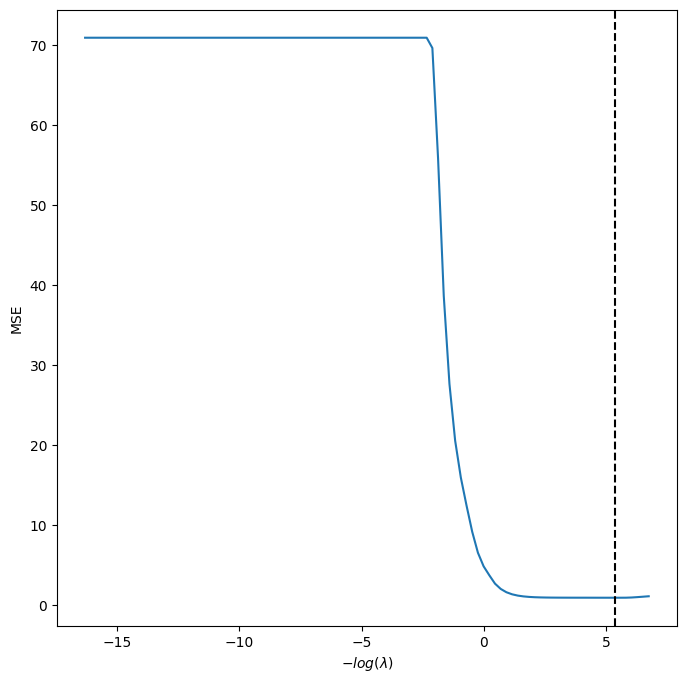

In [235]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylabel('MSE')
ax.set_xlabel(r'$-log(\lambda)$')

Lets have a look at the coefficient estimates of the lasso model

In [236]:
lasso_coefs = pd.Series(data=tuned_lasso.coef_.T, index=['Const', 'X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
lasso_coefs

Const    0.000000
X        6.352222
X2      -2.021187
X3       1.154284
X4      -0.000000
X5      -0.000000
X6      -0.000000
X7      -0.000000
X8      -0.000000
X9       0.000000
X10     -0.227000
dtype: float64

We can see that many of the coefficient estimates have been shrunk to 0. Furthermore, the lasso has correctly identified all of the predictors that have a relationship with response (except the intercept), it has incorrectly identified $X^{10}$ as being a significant predictor 

*(f) Now generate a response vector $Y$ according to the model*

$$
Y = \beta_{0} + \beta_{7}X^{7} + \epsilon
$$

Perform forward stepwise selection and the lasso. Discuss the results obtained

In [237]:
y = 5 + 2*X**7 + e

y.shape

(100,)

In [238]:
fsr_predictors = forward_stepwise_regression(X_full, y, nCp_frozen)
fsr_predictors

[6, 1, 8]

In [239]:
fsr_selected_predictors = pd.DataFrame(data=sm.add_constant(X_full[:, fsr_predictors]), columns=['Const', 'X7', 'X2', 'X9'])
fsr_model = sm.OLS(y, fsr_selected_predictors).fit()
fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.178e+06
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          5.44e-219
Time:                        10:52:50   Log-Likelihood:                -131.90
No. Observations:                 100   AIC:                             271.8
Df Residuals:                      96   BIC:                             282.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          4.8434      0.119     40.557      0.000       4.606       5.080
X7             1.9859      0.009    214.680      0.000       1.968       2.004
X2             0.2084      0.104      2.013      0.047       0.003       0.414
X9             0.0022      0.001      1.647      0.103      -0.000       0.005
==============================================================================
Omnibus:                        1.722   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.454
Skew:                           0.137   Prob(JB):                        0.483
Kurtosis:                       2.476   Cond. No.                         917.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
pipeline.fit(sm.add_constant(X_full), y)
tuned_lasso = pipeline.named_steps['lasso']

In [241]:
lasso_coefs = pd.Series(data=tuned_lasso.coef_.T, index=['Const', 'X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
lasso_coefs

Const     0.000000
X         1.924126
X2       -1.606710
X3      -18.010308
X4        7.621669
X5       67.629525
X6       -8.550642
X7       68.858265
X8       -2.852450
X9       47.270143
X10      -0.371208
dtype: float64

**2.In this exercise, we will predict the number of applications received using the other variables in the College data set.**

In [242]:
college = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\College.csv')
college.head()

Unnamed: 0 Private  Apps  Accept  Enroll  Top10perc  \
0  Abilene Christian University     Yes  1660    1232     721         23   
1            Adelphi University     Yes  2186    1924     512         16   
2                Adrian College     Yes  1428    1097     336         22   
3           Agnes Scott College     Yes   417     349     137         60   
4     Alaska Pacific University     Yes   193     146      55         16   

   Top25perc  F.Undergrad  P.Undergrad  Outstate  Room.Board  Books  Personal  \
0         52         2885          537      7440        3300    450      2200   
1         29         2683         1227     12280        6450    750      1500   
2         50         1036           99     11250        3750    400      1165   
3         89          510           63     12960        5450    450       875   
4         44          249          869      7560        4120    800      1500   

   PhD  Terminal  S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0   70        78       18.1           12    7041         60  
1   29        30       12.2           16   10527         56  
2   53        66       12.9           30    8735         54  
3   92        97        7.7           37   19016         59  
4   76        72       11.9            2   10922         15

In [243]:
college.rename(columns={'Unnamed: 0':'College'}, inplace=True)

In [244]:
college.isnull().sum(axis=0)

College        0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [245]:
college.describe()

Apps        Accept       Enroll   Top10perc   Top25perc  \
count    777.000000    777.000000   777.000000  777.000000  777.000000   
mean    3001.638353   2018.804376   779.972973   27.558559   55.796654   
std     3870.201484   2451.113971   929.176190   17.640364   19.804778   
min       81.000000     72.000000    35.000000    1.000000    9.000000   
25%      776.000000    604.000000   242.000000   15.000000   41.000000   
50%     1558.000000   1110.000000   434.000000   23.000000   54.000000   
75%     3624.000000   2424.000000   902.000000   35.000000   69.000000   
max    48094.000000  26330.000000  6392.000000   96.000000  100.000000   

        F.Undergrad   P.Undergrad      Outstate   Room.Board        Books  \
count    777.000000    777.000000    777.000000   777.000000   777.000000   
mean    3699.907336    855.298584  10440.669241  4357.526384   549.380952   
std     4850.420531   1522.431887   4023.016484  1096.696416   165.105360   
min      139.000000      1.000000   2340.000000  1780.000000    96.000000   
25%      992.000000     95.000000   7320.000000  3597.000000   470.000000   
50%     1707.000000    353.000000   9990.000000  4200.000000   500.000000   
75%     4005.000000    967.000000  12925.000000  5050.000000   600.000000   
max    31643.000000  21836.000000  21700.000000  8124.000000  2340.000000   

          Personal         PhD    Terminal   S.F.Ratio  perc.alumni  \
count   777.000000  777.000000  777.000000  777.000000   777.000000   
mean   1340.642214   72.660232   79.702703   14.089704    22.743887   
std     677.071454   16.328155   14.722359    3.958349    12.391801   
min     250.000000    8.000000   24.000000    2.500000     0.000000   
25%     850.000000   62.000000   71.000000   11.500000    13.000000   
50%    1200.000000   75.000000   82.000000   13.600000    21.000000   
75%    1700.000000   85.000000   92.000000   16.500000    31.000000   
max    6800.000000  103.000000  100.000000   39.800000    64.000000   

             Expend  Grad.Rate  
count    777.000000  777.00000  
mean    9660.171171   65.46332  
std     5221.768440   17.17771  
min     3186.000000   10.00000  
25%     6751.000000   53.00000  
50%     8377.000000   65.00000  
75%    10830.000000   78.00000  
max    56233.000000  118.00000

In [246]:
college['Const'] = 1

In [247]:
college['Private'] = (college['Private'] == 'Yes').astype(float)

*(a) Split the data set into a training set and a test set.*

In [248]:
train_x, test_x, train_y, test_y = skm.train_test_split(college.drop(['Apps', 'College'], axis=1), college['Apps'], random_state=42)

In [249]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((582, 18), (195, 18), (582,), (195,))

*(b) Fit a linear model using least squares on the training set, and report the test error obtained*

In [250]:
apps_ols_model = sm.OLS(train_y, train_x).fit()
apps_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     553.7
Date:                Fri, 09 Aug 2024   Prob (F-statistic):               0.00
Time:                        10:52:50   Log-Likelihood:                -4809.1
No. Observations:                 582   AIC:                             9654.
Df Residuals:                     564   BIC:                             9733.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Private      -626.4455    152.328     -4.112      0.000    -925.646    -327.245
Accept          1.7156      0.043     39.588      0.000       1.630       1.801
Enroll         -1.2578      0.198     -6.368      0.000      -1.646      -0.870
Top10perc      43.8312      5.805      7.551      0.000      32.429      55.233
Top25perc     -10.0355      4.716     -2.128      0.034     -19.298      -0.773
F.Undergrad     0.0626      0.035      1.775      0.076      -0.007       0.132
P.Undergrad    -0.0126      0.042     -0.299      0.765      -0.096       0.070
Outstate       -0.0763      0.020     -3.814      0.000      -0.116      -0.037
Room.Board      0.1739      0.052      3.369      0.001       0.072       0.275
Books           0.1170      0.261      0.448      0.654      -0.396       0.629
Personal        0.0614      0.067      0.910      0.363      -0.071       0.194
PhD           -10.5702      5.103     -2.071      0.039     -20.593      -0.547
Terminal       -1.1547      5.484     -0.211      0.833     -11.926       9.617
S.F.Ratio      13.0572     13.433      0.972      0.331     -13.327      39.441
perc.alumni     0.6542      4.412      0.148      0.882      -8.012       9.320
Expend          0.0442      0.012      3.544      0.000       0.020       0.069
Grad.Rate       7.0856      3.021      2.345      0.019       1.151      13.020
Const        -259.5390    436.386     -0.595      0.552   -1116.679     597.601
==============================================================================
Omnibus:                      366.204   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9238.224
Skew:                           2.316   Prob(JB):                         0.00
Kurtosis:                      21.961   Cond. No.                     1.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [251]:
apps_ols_preds = apps_ols_model.predict(test_x)
apps_ols_mse = mean_squared_error(test_y, apps_ols_preds)
apps_ols_mse

1817982.6455285782

*(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.*

In [252]:
lambdas = 10**np.linspace(8, -2, 1000) / college['Apps'].std()
scaler = StandardScaler(with_mean=True, with_std=True)
ridge = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas)
apps_ridge_pipeline = Pipeline([('scaler', scaler), ('ridge', ridge)])

In [253]:
apps_ridge_pipeline.fit(train_x, train_y)

c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3729649337.330469, tolerance: 746024.0927655915
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_c

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.58384481e+04, 2.52497112e+04, 2.46743889e+04, 2.41121754e+04,
       2.35627722e+04, 2.30258873e+04, 2.25012355e+04, 2.19885380e+04,
       2.14875225e+04, 2.09979228e+04, 2.05194788e+04, 2.00519362e+04,
       1.95950468e+04, 1.91485677e+04, 1.87122618e+04, 1.82858972e+04,
       1.78692475e+04, 1.74620913e+04,...
       4.39032484e-06, 4.29028996e-06, 4.19253440e-06, 4.09700624e-06,
       4.00365471e-06, 3.91243022e-06, 3.82328431e-06, 3.73616962e-06,
       3.65103987e-06, 3.56784982e-06, 3.48655528e-06, 3.40711306e-06,
       3.32948095e-06, 3.25361772e-06, 3.17948306e-06, 3.10703757e-06,
       3.03624278e-06, 2.96706107e-06, 2.89945568e-06, 2.83339071e-06,
       2.76883104e-06, 2.70574238e-06, 2.64409122e-06, 2.58384481e-06]),
                              l1_ratio=0))])

In [254]:
apps_ridge_preds = apps_ridge_pipeline.predict(test_x)
apps_ridge_mse = mean_squared_error(test_y, apps_ridge_preds)
apps_ridge_mse

1817940.9241706112

*(d) Fit a lasso model on the training set, with $\lambda$ chosen by cross validation. Report the test error along with the coefficients*

In [255]:
lasso = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas)
apps_lasso_pipeline = Pipeline([('scaler', scaler), ('lasso', lasso)])

In [256]:
apps_lasso_pipeline.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([2.58384481e+04, 2.52497112e+04, 2.46743889e+04, 2.41121754e+04,
       2.35627722e+04, 2.30258873e+04, 2.25012355e+04, 2.19885380e+04,
       2.14875225e+04, 2.09979228e+04, 2.05194788e+04, 2.00519362e+04,
       1.95950468e+04, 1.91485677e+04, 1.87122618e+04, 1.82858972e+04,
       1.78692475e+04, 1.74620913e+04,...
       4.39032484e-06, 4.29028996e-06, 4.19253440e-06, 4.09700624e-06,
       4.00365471e-06, 3.91243022e-06, 3.82328431e-06, 3.73616962e-06,
       3.65103987e-06, 3.56784982e-06, 3.48655528e-06, 3.40711306e-06,
       3.32948095e-06, 3.25361772e-06, 3.17948306e-06, 3.10703757e-06,
       3.03624278e-06, 2.96706107e-06, 2.89945568e-06, 2.83339071e-06,
       2.76883104e-06, 2.70574238e-06, 2.64409122e-06, 2.58384481e-06]),
                              l1_ratio=1))])

In [257]:
apps_lasso_preds = apps_lasso_pipeline.predict(test_x)
apps_lasso_mse = mean_squared_error(test_y, apps_lasso_preds)
apps_lasso_mse

1817982.6332071854

In [258]:
apps_lasso_pipeline.named_steps['lasso'].coef_.T

array([ -276.3392168 ,  4311.78633764, -1098.95945969,   756.15621634,
        -194.51747967,   283.30749603,   -16.36149961,  -301.19972025,
         190.86806512,    18.78553761,    41.01628902,  -172.47638138,
         -17.30475656,    52.13619727,     7.86006678,   232.97435793,
         123.31605097,     0.        ])

*(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.*

To fit a PCR model we must first find the optimal number of principle components. We can do this using `GridSearchCV` class provided by sklearn.

In [259]:
#sklearns linear regression fits a const by default
train_x, test_x, train_y, test_y = skm.train_test_split(college.drop(['Apps', 'College', 'Const'], axis=1), college['Apps'], random_state=42)

#Full data sets to find the optimal value for the n_components
X = college.drop(['Apps', 'College', 'Const'], axis=1)
y = college['Apps']

In [260]:
scaler = StandardScaler()
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
apps_pcr_pipe = Pipeline([('scaler', scaler),
                          ('pca', pca),
                          ('linreg', linreg)])


In [261]:
param_grid = {'pca__n_components': range(1, 18)}
grid = skm.GridSearchCV(apps_pcr_pipe,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

lets plot the results.

We can see that the lowest MSE is with 17 principal components. However, the MSE isn't much different from the model with two principal components. To keep the model as simple as possible we will select 2 as our optimal number of components.

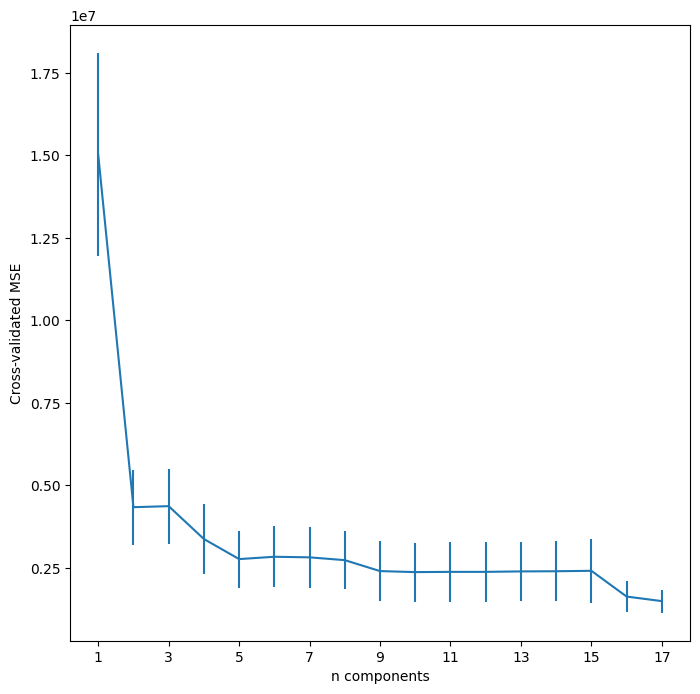

In [262]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, 
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5)) #number of folds
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('n components')
ax.set_xticks(n_comp[::2])


In [263]:
apps_pcr_pipe.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('linreg', LinearRegression())])

In [264]:
apps_pcr_preds = apps_pcr_pipe.predict(test_x)
apps_pcr_mse = mean_squared_error(apps_pcr_preds, test_y)
apps_pcr_mse

3312707.843738734

*(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.*

In [265]:
scaler = StandardScaler()
pls = PLSRegression()
apps_pls_pipe = Pipeline([('scaler', scaler), ('pls', pls)])

In [266]:
param_grid = {'pls__n_components': range(1, 17)}
grid = skm.GridSearchCV(apps_pls_pipe,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pls', PLSRegression())]),
             param_grid={'pls__n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

We can see that the MSE is minimised at 13 components. However, a simpler model with 5 components gives almost the same accuracy and will generalise better to the test data.

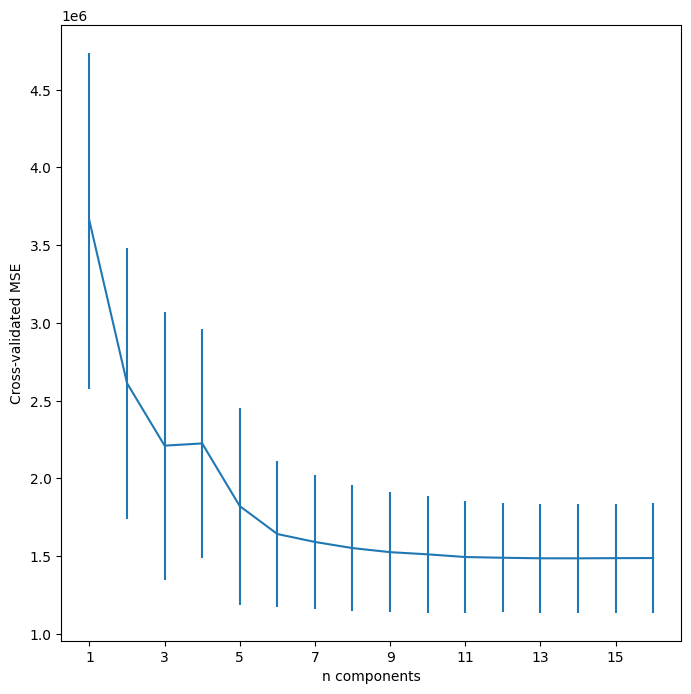

In [267]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
n_comp = param_grid['pls__n_components']
ax.errorbar(n_comp, 
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5)) #number of folds
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('n components')
ax.set_xticks(n_comp[::2])


In [268]:
pls = PLSRegression(n_components=5)
apps_pls_pipe = Pipeline([('scaler', scaler), ('pls', pls)])

In [269]:
apps_pls_pipe.fit(train_x, train_y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=5))])

In [270]:
apps_pls_pred = apps_pls_pipe.predict(test_x)
apps_pls_mse = mean_squared_error(test_y, apps_pls_pred)
apps_pls_mse

1787673.8195432685

*(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?*

We can see that OLS, Ridge, Lasso and PLS all give similar mean squared errors. The PCR is notably worse at predicting application

<Axes: title={'center': 'MSE by model'}, xlabel='Model'>

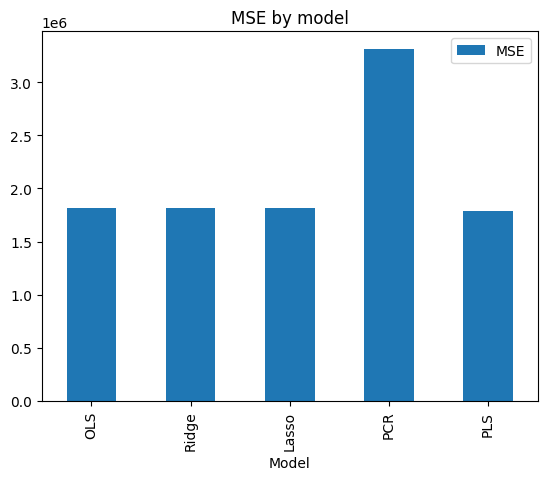

In [271]:
mse_df = pd.DataFrame(data = {
    'Model':['OLS', 'Ridge', 'Lasso', 'PCR', 'PLS'],
    'MSE':[apps_ols_mse, apps_ridge_mse, apps_lasso_mse, apps_pcr_mse, apps_pls_mse]
})
mse_df.set_index('Model').plot(kind='bar', title='MSE by model')

**3.We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.**

*(a) Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model*

$$
Y = X\beta + \epsilon
$$

*where $\beta$ has some elements that are exactly equal to zero.*

In [272]:
np.random.seed(51)
X_1 = np.random.randn(1000) * 10
X = np.power.outer(X_1, np.arange(1, 21))
beta = np.random.randint(low=0, high=5, size=(1, 20))
epsilon = np.random.randn(1000)

In [273]:
beta

array([[0, 2, 4, 0, 3, 0, 0, 2, 4, 1, 1, 2, 3, 2, 1, 0, 3, 4, 2, 0]])

In [274]:
len(list(filter(lambda x: x==0, beta.reshape(-1, 1))))

6

In [275]:
X.shape, beta.shape, epsilon.shape

((1000, 20), (1, 20), (1000,))

In [276]:
y = (X*beta).sum(axis=1) + epsilon

*(b) Split your data set into a training set containing 100 observations and a test set containing 900 observations.*

In [277]:
train_x, test_x, train_y, test_y = skm.train_test_split(X, y, test_size=0.9, random_state=51)

In [278]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((100, 20), (900, 20), (100,), (900,))

*(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.*

There is no built in best subset selection in python, we can write a function that performs best subset selection using training MSE as a performance metric. 

In [279]:
def best_subset_selection(train_predictors, train_response):
    """
    Performs best subset selection given a set of predictors and the response.
    
    Best subset finds the model with the lowest training mse for each possible size
    of the predictor set. 

    For example we find the single predictor that results in the lowest MSE, then the best
    pair, best triplet and so on.
    """
    best_subsets = []
    predictor_index = range(train_predictors.shape[1])
    for size in range(1, len(predictor_index)+1):
        best_model = None
        best_subset = None
        min_mse = float('inf')
        subsets = combinations(predictor_index, size)
        for subset in subsets:
            predictor_subset = train_predictors[:, subset]
            model = sm.OLS(train_response, predictor_subset).fit()
            model_preds = model.predict(predictor_subset)
            model_mse = mean_squared_error(train_response, model_preds)

            if model_mse < min_mse:
                best_model = model
                min_mse = model_mse
                best_subset = subset
        
        best_subsets.append((best_model, best_subset, min_mse)) #append the model with the lowest train mse and the predictor subset 
    
    return best_subsets





In [280]:
best_subsets = best_subset_selection(train_x, train_y)
best_subsets

[(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc4127d0>,
  (18,),
  8.487954891440268e+46),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc3b0610>,
  (17, 18),
  1.9212240414874096e+43),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc3b9e90>,
  (16, 17, 18),
  1.0078366523165093e+35),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc3c1950>,
  (14, 16, 17, 18),
  6.048294438116043e+33),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc397790>,
  (13, 14, 16, 17, 18),
  9.388084127586157e+28),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc499010>,
  (12, 13, 14, 16, 17, 18),
  3.720180495037423e+26),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc4b47d0>,
  (11, 12, 13, 14, 16, 17, 18),
  2.2145671787108714e+24),
 (<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2d2fc4b5490>,
  (1, 11, 

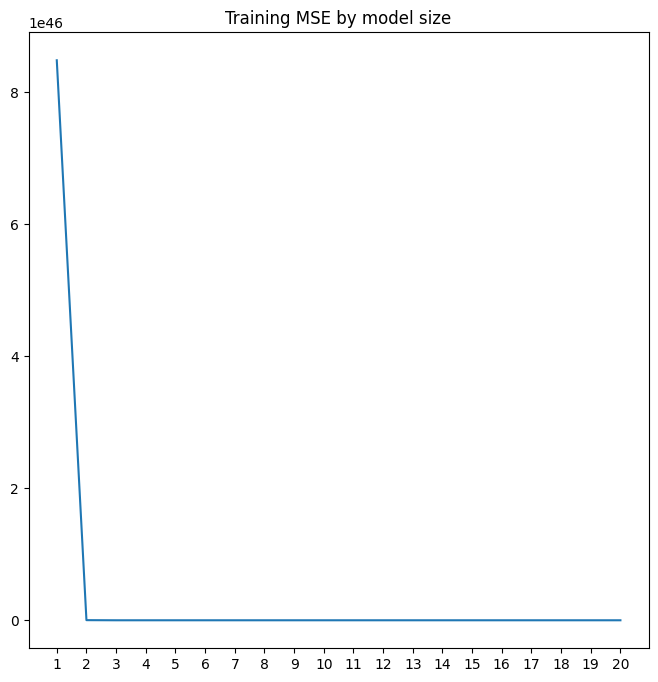

In [281]:
training_mse = [i[2] for i in best_subsets]
sizes = [i+1 for i in range(len(best_subsets))]
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(sizes, training_mse)
ax.set_title('Training MSE by model size')
ax.set_xticks(sizes);

If we plot the training mse on a log scale we can better see how the MSE changes with model size. 

The MSE descreases until a model size of 8 where it then stays around the same until we get to a model size of 18 where it starts to increase again.

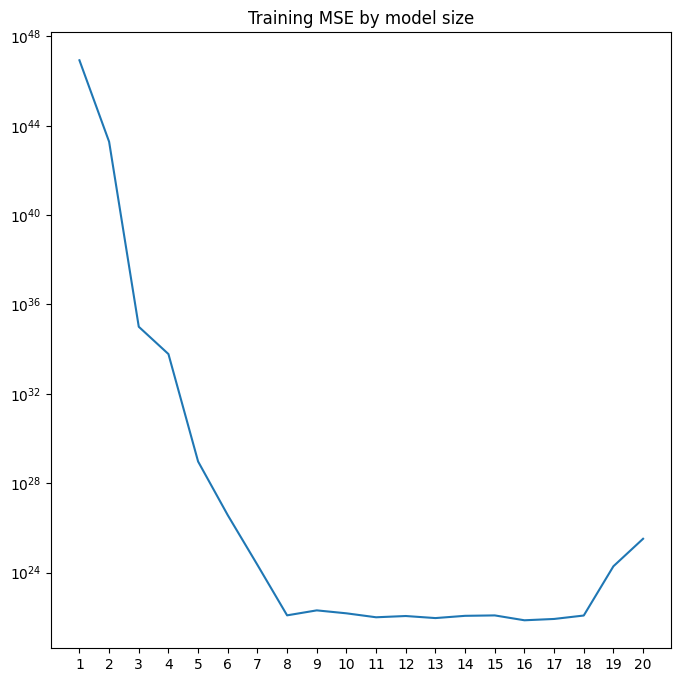

In [282]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(sizes, training_mse)
ax.set_yscale('log')
ax.set_title('Training MSE by model size')
ax.set_xticks(sizes);

*(d) Plot the test set MSE associated with the best model of each size.*

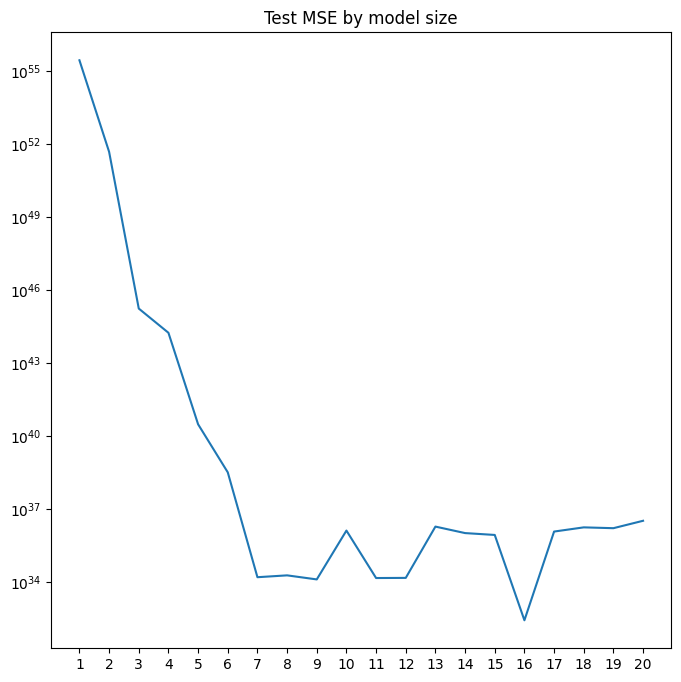

In [283]:
test_mse = [mean_squared_error(test_y, best_subset[0].predict(test_x[:, best_subset[1]])) for best_subset in best_subsets]
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(sizes, test_mse)
ax.set_yscale('log')
ax.set_title('Test MSE by model size')
ax.set_xticks(sizes);

*(e) For which model size does the test set MSE take on its minimum value?*

The test MSE takes on a minimum for a model with 16 predictors.

*(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.*

In [284]:
best_model_test_mse = best_subsets[15]
best_model_predictors = [f'X{best_model_test_mse[1][i]}' for i in range(len(best_model_test_mse[1]))]
best_model_predictors

['X1',
 'X2',
 'X3',
 'X4',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X16',
 'X17',
 'X18']

We can see that the lower order polynomial coefficients have not been predicted very well. However, the coefficients for the higher order ploynomials are very accurate

In [285]:
list(zip(best_model_predictors, best_model_test_mse[0].params, [beta[0][i] for i in best_model_test_mse[1]]))

[('X1', 2.2032509150449187e-10, 2),
 ('X2', -0.0068817138671875, 4),
 ('X3', -1.9147992134094238e-05, 0),
 ('X4', 4.6868808567523956e-07, 3),
 ('X6', 0.00014320015907287598, 0),
 ('X7', 0.0006518363952636719, 2),
 ('X8', 0.01561737060546875, 4),
 ('X9', 0.05800628662109375, 1),
 ('X10', 1.0810546875, 1),
 ('X11', 2.007436752319336, 2),
 ('X12', 2.999490737915039, 3),
 ('X13', 1.9999837130308151, 2),
 ('X14', 1.0000013411045074, 1),
 ('X16', 2.999999998763087, 3),
 ('X17', 4.000000000022197, 4),
 ('X18', 1.9999999999999503, 2)]

*(g) Create a plot displaying $\sqrt{\sum_{j=1}^{p}(\beta_{j} - \hat{\beta}^{r}_{j})^{2}}$ for a range of values of r where $\hat{\beta}^{r}_{j}$ is the $j^{th}$ coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the test MSE plot.*

In [286]:
sizes = []
sqrt_sqrd_coef_diffs = []
for i, subset in enumerate(best_subsets):
    betas_j = [beta[0][i] for i in subset[1]]
    beta_hat_rj = subset[0].params
    sqrt_sqrd_coef_diff = sum((betas_j - beta_hat_rj)**2)**(1/2)
    sizes.append(i+1)
    sqrt_sqrd_coef_diffs.append(sqrt_sqrd_coef_diff)

    

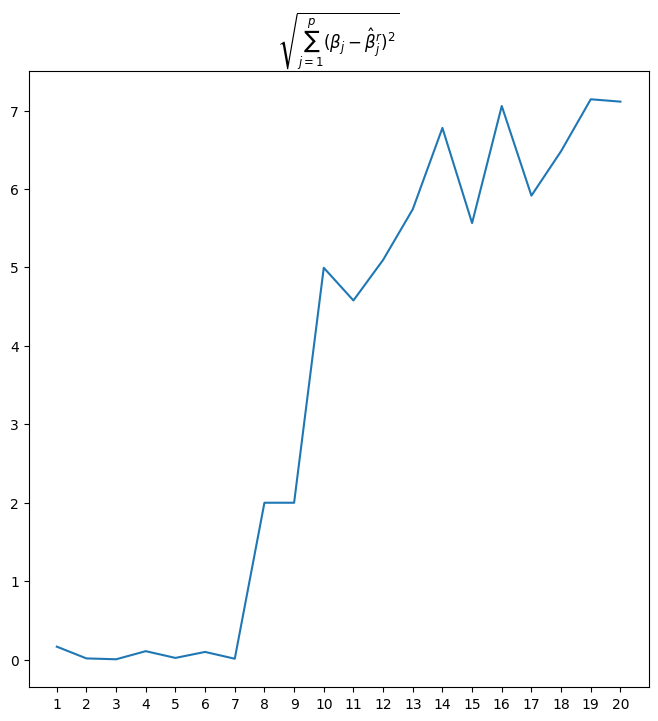

In [287]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(sizes, sqrt_sqrd_coef_diffs)
ax.set_title(r'$\sqrt{\sum_{j=1}^{p}(\beta_{j} - \hat{\beta}^{r}_{j})^{2}}$')
ax.set_xticks(sizes);

**4. We will now try to predict per capita crime rate in the Boston data set.**

In [288]:
boston = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\Boston.csv')
boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2

In [289]:
boston.shape

(506, 14)

In [290]:
boston.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

We could impute the missing values - for this exercise we will just remove them

In [291]:
boston = boston.dropna(how='any')

In [292]:
boston.shape

(394, 14)

*(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider*

In [293]:
boston_X = boston.drop('CRIM', axis=1)
boston_y = boston['CRIM']

boston_X.shape, boston_y.shape

((394, 13), (394,))

In [294]:
boston_train_X, boston_test_X, boston_train_y, boston_test_y = skm.train_test_split(boston_X, boston_y, test_size=0.25, random_state=42)
boston_train_X.shape, boston_test_X.shape, boston_train_y.shape, boston_test_y.shape

((295, 13), (99, 13), (295,), (99,))

## Forward Stepwise regression

In [295]:
full_model = sm.OLS(boston_train_y, sm.add_constant(boston_train_X)).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     16.81
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           2.26e-28
Time:                        11:01:26   Log-Likelihood:                -1013.6
No. Observations:                 295   AIC:                             2055.
Df Residuals:                     281   BIC:                             2107.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.2782     11.690      1.820      0.070      -1.733      44.289
ZN             0.0579      0.029      1.967      0.050   -4.24e-05       0.116
INDUS         -0.0078      0.140     -0.056      0.955      -0.283       0.268
CHAS          -1.9024      1.855     -1.026      0.306      -5.554       1.749
NOX          -14.6372      8.339     -1.755      0.080     -31.051       1.777
RM             1.7652      1.013      1.743      0.082      -0.228       3.759
AGE           -0.0173      0.028     -0.612      0.541      -0.073       0.038
DIS           -1.4408      0.451     -3.197      0.002      -2.328      -0.554
RAD            0.7307      0.135      5.407      0.000       0.465       0.997
TAX           -0.0105      0.008     -1.273      0.204      -0.027       0.006
PTRATIO       -0.4425      0.299     -1.481      0.140      -1.031       0.145
B             -0.0027      0.006     -0.495      0.621      -0.014       0.008
LSTAT          0.1062      0.111      0.953      0.342      -0.113       0.326
MEDV          -0.4054      0.108     -3.769      0.000      -0.617      -0.194
==============================================================================
Omnibus:                      368.387   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24542.897
Skew:                           5.684   Prob(JB):                         0.00
Kurtosis:                      46.215   Cond. No.                     1.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
sigma2 = full_model.scale
print(sigma2)
nCp_frozen = partial(nCp, sigma2)

59.28829418651231


In [297]:
boston_fsr_predictors = forward_stepwise_regression(boston_train_X.to_numpy(), boston_train_y.to_numpy(), nCp_frozen)
boston_fsr_predictors

[7, 12, 9, 4, 11]

In [298]:
boston_fsr_predictors = boston_train_X.columns[boston_fsr_predictors]
boston_fsr_predictors

Index(['RAD', 'MEDV', 'PTRATIO', 'RM', 'LSTAT'], dtype='object')

In [299]:
boston_fsr_model = sm.OLS(boston_train_y, sm.add_constant(boston_train_X[boston_fsr_predictors])).fit()
boston_fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     39.95
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           3.76e-31
Time:                        11:01:26   Log-Likelihood:                -1020.9
No. Observations:                 295   AIC:                             2054.
Df Residuals:                     289   BIC:                             2076.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1169      8.473     -0.132      0.895     -17.793      15.559
RAD            0.5696      0.066      8.634      0.000       0.440       0.699
MEDV          -0.2866      0.097     -2.941      0.004      -0.478      -0.095
PTRATIO       -0.4130      0.265     -1.556      0.121      -0.935       0.109
RM             1.8767      0.973      1.930      0.055      -0.037       3.791
LSTAT          0.1423      0.100      1.420      0.157      -0.055       0.339
==============================================================================
Omnibus:                      370.774   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24866.017
Skew:                           5.749   Prob(JB):                         0.00
Kurtosis:                      46.483   Cond. No.                         635.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
fsr_error = mean_squared_error(boston_fsr_model.predict(sm.add_constant(boston_test_X[boston_fsr_predictors])), boston_test_y)
fsr_error

22.037580821428183

## Backward Stepwise Regression

In [301]:
boston_bsr_predictors = backward_stepwise_regression(boston_X.to_numpy(), boston_y.to_numpy(), nCp_frozen)
boston_bsr_predictors

[0, 3, 6, 7, 9, 10, 12]

In [302]:
boston_bsr_predictors = boston_train_X.columns[boston_bsr_predictors]
boston_bsr_predictors

Index(['ZN', 'NOX', 'DIS', 'RAD', 'PTRATIO', 'B', 'MEDV'], dtype='object')

In [303]:
boston_bsr_model = sm.OLS(boston_train_y, sm.add_constant(boston_train_X[boston_bsr_predictors])).fit()
boston_bsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     30.25
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           3.32e-31
Time:                        11:01:26   Log-Likelihood:                -1016.9
No. Observations:                 295   AIC:                             2050.
Df Residuals:                     287   BIC:                             2079.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.4672      9.388      3.245      0.001      11.989      48.945
ZN             0.0534      0.028      1.927      0.055      -0.001       0.108
NOX          -17.9110      7.598     -2.357      0.019     -32.866      -2.956
DIS           -1.2495      0.391     -3.197      0.002      -2.019      -0.480
RAD            0.6071      0.078      7.790      0.000       0.454       0.761
PTRATIO       -0.4928      0.295     -1.669      0.096      -1.074       0.088
B             -0.0054      0.005     -1.004      0.316      -0.016       0.005
MEDV          -0.3258      0.073     -4.476      0.000      -0.469      -0.182
==============================================================================
Omnibus:                      373.221   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26384.082
Skew:                           5.790   Prob(JB):                         0.00
Kurtosis:                      47.860   Cond. No.                     9.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [304]:
bsr_error = mean_squared_error(boston_bsr_model.predict(sm.add_constant(boston_test_X[boston_bsr_predictors])), boston_test_y)
bsr_error

20.50641477843207

## Lasso & Ridge

We have already seen how to build pipelines to fit lasso and ridge regression models. Lets build these again for practice

In [305]:
lasso_scaler = StandardScaler()
lambdas = 10**np.linspace(8, -2, 100) / boston_y.std()
lasso = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=5)
lasso_pipeline = Pipeline(steps=[
    ('scaler', lasso_scaler),
    ('lasso', lasso)
])

In [306]:
ridge_scaler = StandardScaler()
ridge = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0)
ridge_pipeline = Pipeline(steps=[
    ('scaler', ridge_scaler),
    ('ridge', ridge)
])

In [307]:
lasso_pipeline.fit(sm.add_constant(boston_train_X), boston_train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([1.08667038e+07, 8.61167689e+06, 6.82460666e+06, 5.40838407e+06,
       4.28605188e+06, 3.39662282e+06, 2.69176549e+06, 2.13317812e+06,
       1.69050718e+06, 1.33969803e+06, 1.06168778e+06, 8.41369407e+05,
       6.66770866e+05, 5.28404508e+05, 4.18751536e+05, 3.31853431e+05,
       2.62988169e+05, 2.08413626e+05,...
       2.28733698e-01, 1.81267544e-01, 1.43651428e-01, 1.13841300e-01,
       9.02172836e-02, 7.14956544e-02, 5.66590834e-02, 4.49013547e-02,
       3.55835557e-02, 2.81993593e-02, 2.23475100e-02, 1.77100195e-02,
       1.40348876e-02, 1.11224084e-02, 8.81431844e-03, 6.98519663e-03,
       5.53564887e-03, 4.38690706e-03, 3.47654882e-03, 2.75510549e-03,
       2.18337398e-03, 1.73028654e-03, 1.37122249e-03, 1.08667038e-03]),
                              cv=5, l1_ratio=1))])

In [308]:
boston_tuned_lasso = lasso_pipeline.named_steps['lasso']
boston_tuned_lasso

ElasticNetCV(alphas=array([1.08667038e+07, 8.61167689e+06, 6.82460666e+06, 5.40838407e+06,
       4.28605188e+06, 3.39662282e+06, 2.69176549e+06, 2.13317812e+06,
       1.69050718e+06, 1.33969803e+06, 1.06168778e+06, 8.41369407e+05,
       6.66770866e+05, 5.28404508e+05, 4.18751536e+05, 3.31853431e+05,
       2.62988169e+05, 2.08413626e+05, 1.65164235e+05, 1.30889831e+05,
       1.03727953e+05, 8.220262...
       2.28733698e-01, 1.81267544e-01, 1.43651428e-01, 1.13841300e-01,
       9.02172836e-02, 7.14956544e-02, 5.66590834e-02, 4.49013547e-02,
       3.55835557e-02, 2.81993593e-02, 2.23475100e-02, 1.77100195e-02,
       1.40348876e-02, 1.11224084e-02, 8.81431844e-03, 6.98519663e-03,
       5.53564887e-03, 4.38690706e-03, 3.47654882e-03, 2.75510549e-03,
       2.18337398e-03, 1.73028654e-03, 1.37122249e-03, 1.08667038e-03]),
             cv=5, l1_ratio=1)

In [309]:
lasso_pipeline.feature_names_in_

array(['const', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'], dtype=object)

In [310]:
pd.Series(boston_tuned_lasso.coef_.T, index=lasso_pipeline.feature_names_in_)

const      0.000000
ZN         1.172690
INDUS     -0.188339
CHAS      -0.427090
NOX       -1.382518
RM         1.024938
AGE       -0.276579
DIS       -2.523892
RAD        5.743191
TAX       -1.021743
PTRATIO   -0.783661
B         -0.291304
LSTAT      0.722187
MEDV      -3.145406
dtype: float64

In [311]:
boston_lasso_mse = mean_squared_error(boston_test_y, lasso_pipeline.predict(sm.add_constant(boston_test_X)))
boston_lasso_mse

21.93122994113982

In [312]:
ridge_pipeline.fit(sm.add_constant(boston_train_X), boston_train_y)

c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13734.220541201885, tolerance: 2.746844572904839
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.08667038e+07, 8.61167689e+06, 6.82460666e+06, 5.40838407e+06,
       4.28605188e+06, 3.39662282e+06, 2.69176549e+06, 2.13317812e+06,
       1.69050718e+06, 1.33969803e+06, 1.06168778e+06, 8.41369407e+05,
       6.66770866e+05, 5.28404508e+05, 4.18751536e+05, 3.31853431e+05,
       2.62988169e+05, 2.08413626e+05,...
       2.28733698e-01, 1.81267544e-01, 1.43651428e-01, 1.13841300e-01,
       9.02172836e-02, 7.14956544e-02, 5.66590834e-02, 4.49013547e-02,
       3.55835557e-02, 2.81993593e-02, 2.23475100e-02, 1.77100195e-02,
       1.40348876e-02, 1.11224084e-02, 8.81431844e-03, 6.98519663e-03,
       5.53564887e-03, 4.38690706e-03, 3.47654882e-03, 2.75510549e-03,
       2.18337398e-03, 1.73028654e-03, 1.37122249e-03, 1.08667038e-03]),
                              l1_ratio=0))])

In [313]:
boston_tuned_ridge = ridge_pipeline.named_steps['ridge']
pd.Series(boston_tuned_ridge.coef_, index=ridge_pipeline.feature_names_in_)


const      0.000000
ZN         1.041285
INDUS     -0.426462
CHAS      -0.443813
NOX       -1.082725
RM         1.009821
AGE       -0.349394
DIS       -2.319224
RAD        4.949637
TAX       -0.302967
PTRATIO   -0.644508
B         -0.403965
LSTAT      0.953395
MEDV      -2.790254
dtype: float64

In [314]:
boston_ridge_mse = mean_squared_error(ridge_pipeline.predict(sm.add_constant(boston_test_X)), boston_test_y)
boston_ridge_mse

20.85252693280391